# FTIR Processing

This notebook is going to take us through graphing two FTIR spectra, in both cases we are going to start from the raw interferograms. This is import for a few different reasons, one it allows us to see what is going when the softwear does this but also this process involves a fair amount of processing involved. By being able to directly control this processign we can make changes to best present the data.

For this notebook you will also need to get the 75_BG.txt and 75_AIR.txt files.

## Importing modules 

 > We are going to begin by importing the modules we are going the be using, numpy to help with some math, matplotlib for plotting our figures and finally pandas which is going to help us with reading and analysing the data in our code.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Creating the background spectrum.
>In order to cancel out interferences caused by the instrument and enviornment so that only the sample single is displayed in the end we need to create the background spectrum from the background interferogram.
The interferogram for this is a tab-delimited text file that is named "75_BG.txt", which you will need to set the correct path for.

>Let's look at the code block below, first we set the file name we are looking for as we mentioned this is "75_BG.txt" without the quotes. Then we need to define the path, since this is in the folder we are currently in we can just leave it blank between to quotation marks. The next line is the really important one, here we are reading in the data in the from the file. 


In [3]:
filename = "75_BG.txt" # Sets the variable filename to the name of the file we want

path = "" # Tells the program that the file is in our current directory

data = pd.read_csv(path+filename, header=None, sep='\t', names=["length","inten"])
# in the above line We start by giveing the data the name data, to read in the file 
#we are going to use pandas which we called pd when we imported it. We use the 
#read_csv command in pandas to read the file.  In the parenthesis we set the needed 
#paramaters, path+filename identifies the file we want to read,  header=None tells 
#pandas that there is no header in the file, sep='\t' is used because tab is used 
#to separate the data in the file , finally names=["length","inten"] names each 
#column in the data set.

## Graphing the data
Below we're going to graph the data in the text file, this is the background interferogram, this tells use about how the light is constructivly and destructivly interefered in the Michelson interferometer. This is how the data can be collected so quickly in an FTIR when compared with an IR.
However, as you can see below in its current form it isnt very useful for interpretation. 

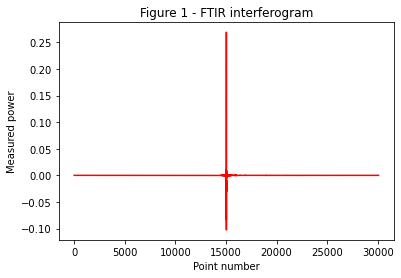

In [7]:
xvals=data['length']
yvals=-data['inten']

plt.plot(xvals,yvals, 'r-')
plt.title("Figure 1 - FTIR interferogram")
plt.xlabel('Point number')
plt.ylabel('Measured power')
plt.show()

### Rescaling the interferogram
At the moment the data is measured intensity (y-axis) and the x-axis is currently just a number, which isn't very meaningful.  We need to turn the x-axis data into a path length difference between the two paths of the Michelson interferometer, it currently represents the motor step controling the movable mirror. Additionally you have probably noticed the large peak in the middle (around the point number 15000), this occurs when the path length difference between the mirrors is zero. This lets us shift all the x-points and then we need to rescale the points to a distance measurement. To shift, I'll just make the middle zero, since the big peak occurs when the pathlength is 0 we just need to shift everything by the halfway point (15000).

In order to rescale the interferogram we need to think about how the spectrometer collects the data. In a modern Michaleson interferometers there are two light sources a white light sourse which is used to do all the spectroscopy (this is the light that is absorbed by the sample) and a laser which shines along the optical path. The laser is used to both measure the distance the mirror moves and is used to trigger the computer into making a measurement. This occurs when the path length difference is equal to a multiple of the wavelength of the laser by activating a switch, this happens every time the laser constructively interferes with itself. In this instrument (and most FTIRs) a HeNe laser is used, these lasers have a wavelength of 633 nm, this means each data point correspoinds to a path length change of 633 nm  (or 6.33 x 10$^{-5}$ cm).

Below we do 4 things, 
First, halfpoint = int(xvals.count()/2), creates a varible named halfpoint and gives it the value of exactly half the number of x-axis points.
Second, shiftedx = xvals - halfpoint, takes all of the xvalues and subtracts the value of the halfway point. This shifts all the xvalues
Third, distanceTraveled = shiftedx * 6.33E-5 converts the xaxis values to the path length difference of the two mirrors in cm.
Finally the next few lines plots the intensity vs path length difference.


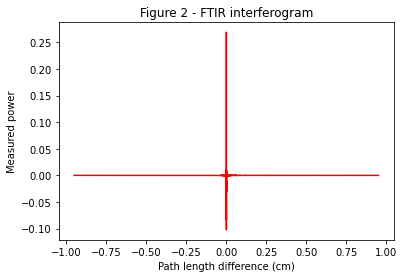

In [8]:
halfpoint = int(xvals.count()/2) # Calculates the halfway point
shiftedx = xvals - halfpoint #shifts the x-axis
distanceTraveled = shiftedx * 6.33E-5 #Scales the x-axis 
plt.plot(distanceTraveled,yvals, 'r-')
plt.title("Figure 2 - FTIR interferogram")
plt.xlabel('Path length difference (cm)')
plt.ylabel('Measured power')
plt.show()

## Fourier transforming the data

To turn our interferogram into a spectrum, we need to Fourier Transform it. To do that, we will use the Fast Fourier Transform (FFT) algorithm that is built into the numpy package, which is called fft.fft(). Because the Fourier Transform can have complex values, we'll need to also make sure everything is real (so we can graph it). There are a few ways to do this easiest is to square the real and imaginary components, add them together, and then take the square root. So let's try it out!

In [9]:
fftdata_inter = np.fft.fft(yvals) # Fourier transforms the y values
specInten_inter=np.sqrt(fftdata_inter.real**2 + fftdata_inter.imag**2) # Squaring the real and imaginary parts

What does the Fourier transformed data look like?

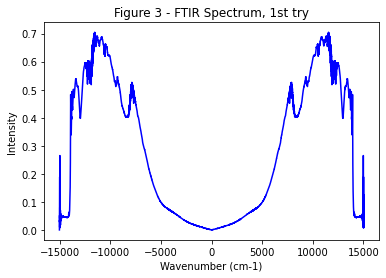

In [11]:
plt.plot(shiftedx,specInten_inter, 'b-')
ax = plt.gca()
plt.title("Figure 3 - FTIR Spectrum, 1st try")
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.show()

We can see some features in the above plot that look like an absorption spectrum but clearly there are still some issues. First, the x-axis has negative values (which doesnt make sense in reality, and the plot looks mirrored). We are going to fix these two issues together,

To start to do this we need to go back to the interferogram.
The reason why our wavenumbers start negative is because the interferogram has its peak in the middle. Now even though in reality we want the peak in the middle becasue it occurs when the path length differeince is zero, for post-processign reasons we need to tak ethe FT with the peak at the beginning of the data. So, we need to find the middle of the peak in the interferogram, and make that the start of the data, then move everything in the interferogram around. Here's what the interferogram looks like after rotating:

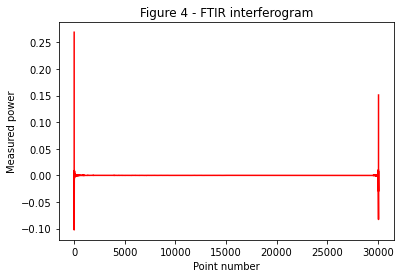

In [12]:
centerMax = yvals.idxmax()
firstHalf = yvals[0:centerMax] 
secondHalf = yvals[centerMax:int(yvals.count())]
rotInten = secondHalf.append(firstHalf, ignore_index=True)
#The above 4 lines of code finds the center of the peak, the shifts that down
# to the start of the data.

plt.plot(xvals,rotInten, 'r-')
plt.title("Figure 4 - FTIR interferogram")
plt.xlabel('Point number')
plt.ylabel('Measured power')
plt.show()

Above, we have the interferogram with the large peak at the start of the data, we can now FFT the interferogram.

In [13]:
fftdata = np.fft.fft(rotInten)
specInten=np.sqrt(fftdata.real**2 + fftdata.imag**2)

Now it's time to address the other issue, which is finding the correct x-axis. This is rather straightforward, as it's essentially just the inverse of the path length difference. The easy way to calculate this is to divide each point corresponding to an x-value by the total path length.

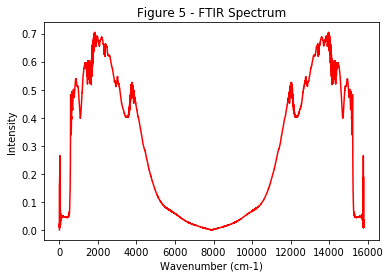

In [9]:
freq = xvals / (xvals.count() * 6.33E-5)
plt.plot(freq, specInten, 'r-')
ax = plt.gca()
plt.title("Figure 5 - FTIR Spectrum")
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.show()

Okay above, it now looks like the x-axis is fixed, however, it's still symmetric. What gives? Because the mirror in the Michelson interferometer moves forwards and backwards (which is why the interferogram is mostly symmetric around zero), when we Fourier Transform the interferogram it will also be a mirror image. Fortunately we can just ignore the second half of the spectrum.

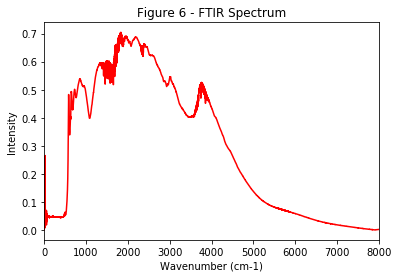

In [10]:
plt.plot(freq, specInten, 'r-')
ax = plt.gca()
ax.set_xlim(0,8000)
plt.title("Figure 6 - FTIR Spectrum")
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.show()

And there we have it, the background spectrum. Now, you graph the spectrum in the second file (75_AIR.txt).

Once you have the spectrum, take the ratio of your spectrum to the background spectrum I graphed, multiply it by 100%, and graph it. This will give you the %T vs. wavenumber.

Regraph the spectrum, zooming in on the area between 3000 and 4000 cm$^{-1}$. 

This is the IR spectrum of a sample of air. Knowing that this is for a gas, how do you explain the  fact that the broad peak in the 3000 to 4000 cm$^{-1}$ range is made up of narrow peaks that can be resolved in this sample? What molecular transitions do these peaks correspond to?

**Answer here**

As I mentioned at the beginning, there is post-processing that we can do to our spectrum. The two most important post-processing steps are apodization, which improves the spectrum resolution, and phase correction, which is the better way to account for the differences between the real and imaginary parts after the FFT. I skipped both of these in this notebook, but I would encourage you to read more about them at [LibreTexts](https://chem.libretexts.org/Textbook_Maps/Analytical_Chemistry/Supplemental_Modules_%28Analytical_Chemistry%29/Instrumental_Analysis/Spectrometer/How_an_FTIR_instrument_works)